# Visualisation 

In [13]:
import os
import torch
import time
import os.path as osp
import pandas as pd
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt


from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.data import Dataset, Data
from tqdm import tqdm

In [2]:
from data.visualize_sample import draw_graph

In [3]:
class OCTADataset(Dataset):
    def __init__(self, root='/media/data/anna_alex/OCTA-500_6mm/train_data', transform=None, pre_transform=None, pre_filter=None):
        img_folder = osp.join(root, 'raw')
        graphs_folder = osp.join(root, 'graphs')

        node_files = []
        edge_files = []

        for file_ in os.listdir(img_folder):
            file_ = file_[:-8]
            node_files.append(osp.join(graphs_folder, file_ + 'seg_nodes.csv'))
            edge_files.append(osp.join(graphs_folder, file_ + 'seg_edges.csv'))

        data_dicts = [
            {"nodes": node_file, "edges": edge_file} for
            node_file, edge_file in zip(node_files, edge_files)
        ]
        self.data = data_dicts
        
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return [d['edges'] for d in self.data]

    @property
    def processed_file_names(self):
        return [f'data_{idx}.pt' for idx, _ in enumerate(self.data)]

    def download(self):
        pass

    def process(self):
        for idx in tqdm(range(len(self.raw_paths))):

            data = self.data[idx]
            nodes = pd.read_csv(data['nodes'], sep=";", index_col="id")
            edges = pd.read_csv(data['edges'], sep=";", index_col="id")
            
            nodes_pos = torch.tensor(nodes.to_numpy()[:, :2].astype(np.float32) / 128.)
            edges = torch.tensor(edges.to_numpy()[:, :2].astype(int)).t()

            nodes_ones = torch.ones(nodes_pos.size(0)).view(-1, 1)

            data = Data(
                x=nodes_ones,
                edge_index=edges,
                pos=nodes_pos,
            )

            torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [14]:
def plot_ged(graph_pairs, timeout=30):
    start_time = time.time()
    rows = len(graph_pairs)
    cols = 2
    
    fig = plt.figure()
    fig.set_size_inches(8, 4 * rows)

    subfigs = fig.subfigures(rows, 1)

    for i, data_pair in tqdm(enumerate(graph_pairs)):
        (ax1, ax2) = subfigs[i].subplots(1, 2)

        graph1 = to_networkx(data_pair[0].to_undirected())
        draw_graph(data_pair[0].pos, data_pair[0].edge_index.t(), ax1)

        graph2 = to_networkx(data_pair[1].to_undirected())
        draw_graph(data_pair[1].pos, data_pair[1].edge_index.t(), ax2)
        
        plt.subplots_adjust(hspace = 0.3)

        distance = nx.graph_edit_distance(graph1, graph2, timeout=timeout)
        subfigs[i].suptitle(f"GED: {distance}", fontsize=12)
        subfigs[i].canvas.draw()
        
    plt.show()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

In [5]:
dataset = OCTADataset()

In [6]:
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

20it [13:56, 41.82s/it]


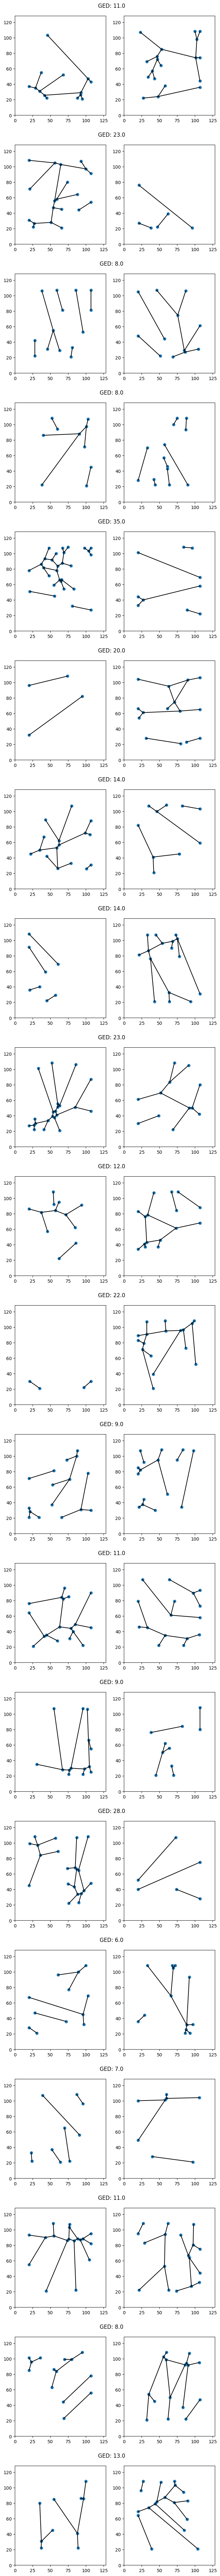

In [12]:
num_pairs = 50
graph_pairs = [next(iter(data_loader)) for _ in range(num_pairs)]

plot_ged(graph_pairs, timeout=20)

14it [03:52, 16.59s/it]


KeyboardInterrupt: 

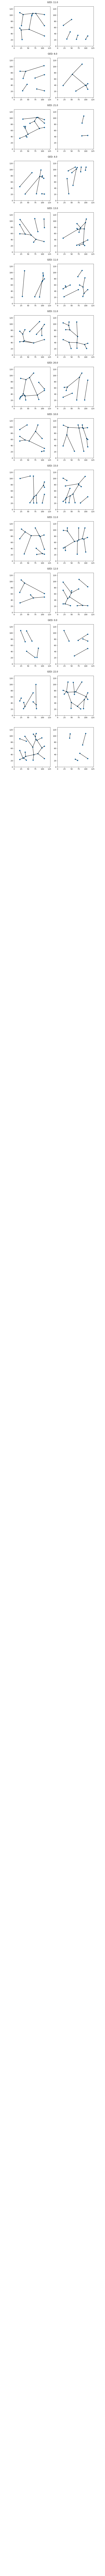

In [15]:
num_pairs = 50
graph_pairs = [next(iter(data_loader)) for _ in range(num_pairs)]

plot_ged(graph_pairs, timeout=20)